<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/ODEint_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install control

     |████████████████████████████████| 256kB 8.3MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=5dff1a5121ad219bf5809747e262ebb125e133641f8eee11f240c94640fb58ae
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


In [0]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from control import *

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

## EXAMPLE PROBLEM
Find a controller that stabilizes the nonlinear system
\begin{align}
\dot x_1 &= \sin(x_1)+x_2^2 +u \\
\dot x_2 &= 3x_1+x_2+2x_2^2 \\
y &= x_2
\end{align}
and plot the closed loop nonlinear dynamics for the system's step response.  

In [87]:
var("x1 x2 u")
xstar = {x1:0,x2:0,u:0}
f = Matrix([[sin(x1)+x2**2 +u],[3*x1+x2+2*x2**2]])
y = Matrix([[x2]])
A = f.jacobian([x1,x2]).subs(xstar)
B = f.jacobian([u]).subs(xstar)
C = y.jacobian([x1,x2]).subs(xstar)
(A,B,C)

⎛⎡1  0⎤  ⎡1⎤        ⎞
⎜⎢    ⎥, ⎢ ⎥, [0  1]⎟
⎝⎣3  1⎦  ⎣0⎦        ⎠

In [0]:
var("s")
G = C*(s*eye(2)-A).inv()*B


In [0]:
Gp = G[0,0]

def sympy_to_tf(G_tf):
  num,den = fraction(G_tf) 
  den_c  = [float(x) for x in poly(den,s).coeffs()]
  num_c = [float(x) for x in poly(num,s).coeffs()]
     
  G = tf(num_c,den_c)
  return G

Gp = sympy_to_tf(G[0,0])

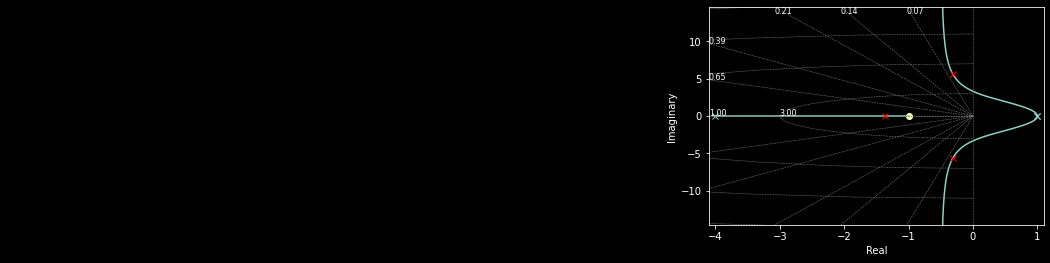

In [94]:
Gc = tf([13,13],[1,4]) #a good enough for demonstration controller
p,k = root_locus(Gp*Gc );
ind = 50
p[ind],k[ind]
#poles at about -1.4 -0.3 +/- 5j}
plt.plot(np.real(p[ind]),np.imag(p[ind]),'xr')

In [45]:
Controller = tf2ss(Gc)
Controller

A = [[-4.]]

B = [[1.]]

C = [[-39.]]

D = [[13.]]

From above, NL dynamics are:
\begin{align}
\dot x_1 &= \sin(x_1)+x_2^2 +u \\
\dot x_2 &= 3x_1+x_2+2x_2^2 \\
y &= x_2
\end{align}

So controller dynamics from $e$ to $u$ are

\begin{align} 
\dot x_3 &= -4x_3+e\\
u &= -39x_3+13e
\end{align}

and $e = r-y$ as always.

Our standard negative feedback loop applies:
![alt text](https://github.com/christakahashi/ECE447/raw/master/images/standard_FB.png)

This gives combined dynamics from $r$ to $y$:

\begin{align}
\dot x_1 &= \sin(x_1)+x_2^2 -39x_3+13r-13x_2 \\
\dot x_2 &= 3x_1+x_2+2x_2^2 \\
\dot x_3 &= -4x_3-x_2+r \\
y &= x_2
\end{align}


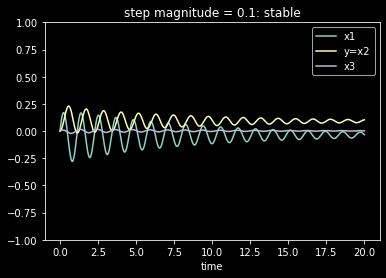

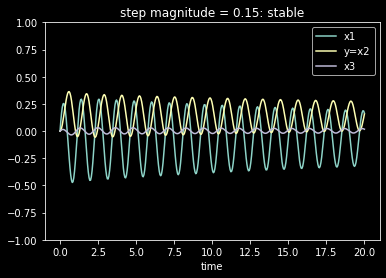

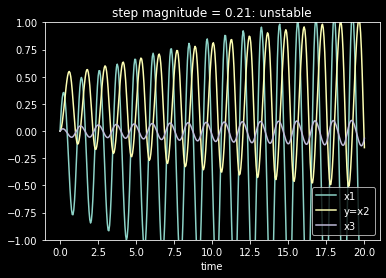

In [103]:
############################################################
#This is an inefficient but maximally easy to read example #
# of using odeint.                                         #
############################################################


#our step input.  only gets called by ffn.  could be part
#of ffn but it sepparate for clarity.
def rfn(t):
  if t>=0.:
    return 1.
  else:
    return 0.

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t,step_magnitude = 0.1):
  #compute r
  #goes unstable for step_magnitude above about 0.2
  # try out 0.1, 0.2, 0.3 
  r = step_magnitude*rfn(t) 

  #extract x1,x2,x3 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]

  #compute f(x,t)
  x1dot = np.sin(x1)+x2*x2-39*x3+13*r - 13*x2
  x2dot = 3*x1+x2+2*x2*x2
  x3dot = -4*x3-x2+r

  #return derivatives.
  return [x1dot,x2dot,x3dot]

t = np.linspace(0,20,400);
for (sm,st) in zip([0.1,0.15,0.21],["stable","stable","unstable"]):
  #args= (sm,) sets the third argument of ffn (step_magnitude) to sm)
  x_of_t = spi.odeint(ffn,(0,0,0),t,args=(sm,)) #start at x=(0,0,0)^T
  plt.figure()
  plt.plot(t,x_of_t)
  plt.ylim(-1 ,1 )
  plt.legend(["x1","y=x2","x3"])
  plt.xlabel("time")
  plt.title("step magnitude = {}: {}".format(sm,st))